## Logistic regressions

In [36]:
import numpy as np

with np.load('cifar4-train.npz', allow_pickle = False) as npz_file:
    cifar4_data = dict(npz_file.items())
    
print(list(cifar4_data.keys()))

X = cifar4_data['overfeat']
y = cifar4_data['labels']

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)

['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']
X: (5000, 4096) float32
y: (5000,) int64


In [37]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float32)

# Split data into train/test sets keeping same proportion of classes
X_tr, X_te, y_tr, y_te, X_pix_tr, X_pix_te = train_test_split(
    X, y, cifar4_data['pixels'], train_size=4000, test_size=1000, random_state=0, stratify = y)

print ('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)

Train set: (4000, 4096) (4000,)
Test set: (1000, 4096) (1000,)


### Create a logistic regression classifier and tune the regularization strength.

In [38]:
#Create a logistic regression estimator with an optional PCA preprocessing step.


#fit a logistic regression with an L2  regularization term and 
#tune the regularization strength using grid search with cross-validation. Use a stratified 5-fold strategy.

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


sgd = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=0)
print(SGDClassifier().get_params().keys())

pipe = Pipeline([
    ('pca', None), #optional step
    ('sgd', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=0))
])



dict_keys(['alpha', 'average', 'class_weight', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'verbose', 'warm_start'])


C:\Users\User1\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [39]:
#Tune the regularization strength and the number of components using grid search with cross-validation. 
#Try with and without PCA.


grid = {
    'sgd__alpha': [0.01, 0.1, 1, 10]
},{
    'pca': [PCA()],
    'pca__n_components': [5, 20, 50, 100, 150],
    'sgd__alpha': [0.01, 0.1, 1, 10]    
}

grid_cv = GridSearchCV(pipe, grid, cv=5)
grid_cv.fit(X_tr, y_tr)
grid_cv.cv_results_.keys()


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_sgd__alpha', 'param_pca', 'param_pca__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [42]:
#Collect the results in a DataFrame, print the best parameters and evaluate the test accuracy.

import pandas as pd
df = pd.DataFrame.from_items([
    ('alpha', grid_cv.cv_results_['param_sgd__alpha']),
    ('n_components', grid_cv.cv_results_['param_pca__n_components']),
    ('mean_score', grid_cv.cv_results_['mean_test_score']),
    ('std_score', grid_cv.cv_results_['std_test_score'])
])

#Find (using code) the combination of parameters that maximizes the mean accuracy and print it. 
idx=np.argmax(df.mean_score)
top_accuracy = df.mean_score[idx]
std_score = df.std_score[idx]
components = df.n_components[idx]
alpha_score = df.alpha[idx]

print('Top accuracy across folds: {:.2f} (std: {:.3f}) with {} components and alpha: {}'.format
      (top_accuracy, std_score, components, alpha_score))


#Evaluate the test accuracy 
pipe.set_params(sgd__alpha=0.1)
pipe.fit(X_tr, y_tr)
accuracy = pipe.score(X_te,y_te)

print('Logistic regression accuracy (test set):{:.3}'.format(accuracy))

df['mean_score'] = df['mean_score'].map('{:,.2f}'.format)
df['std_score'] = df['std_score'].map('{:,.2f}'.format)
df.sort_values(by='mean_score', ascending=False)
df

C:\Users\User1\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Top accuracy across folds: 0.83 (std: 0.017) with nan components and alpha: 0.1
Logistic regression accuracy (test set):0.833


,alpha,n_components,mean_score,std_score
0,0.01,NaN,0.80,0.01
1,0.1,NaN,0.83,0.02
2,1,NaN,0.82,0.01
3,10,NaN,0.79,0.01
4,0.01,5,0.67,0.04
5,0.1,5,0.67,0.04
6,1,5,0.67,0.03
7,10,5,0.64,0.03
8,0.01,20,0.77,0.01
9,0.1,20,0.76,0.01


### Pick ten images from the test set and compute the probabilities for each class.

In [43]:
#pick ten images from the test set and compute the probability of each class using the predict_proba() function of your estimator

probabilities = pipe.predict_proba(X_te[10:20])
print(probabilities.shape)

img_set = X_pix_te[10:20]
print(img_set.shape)

images = ['image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7', 'image8', 'image9', 'image10']

(10, 4)
(10, 3072)


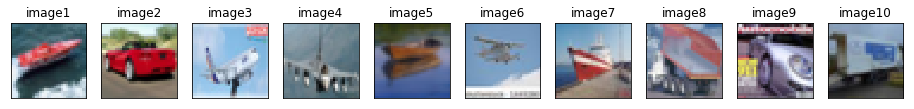

In [44]:
# Plot the results. You can plot the ten images in subplots with the imshow() function 
#and collect the probabilities in a DataFrame.

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(16,4))

for i, axis in enumerate(axes):
    flat_img = img_set[i]
    img_fin=flat_img.reshape(32,32,3)
    
    axis.set_title(images[i])
    axis.imshow(img_fin)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
plt.show()


In [45]:
df_proba = pd.DataFrame(probabilities, index = images, columns = ['truck', 'car', 'airplane', 'ship'])
df_proba = df_proba.applymap("{0:.2f}".format)
df_proba

,truck,car,airplane,ship
image1,0.01,0.01,0.06,0.93
image2,0.22,0.78,0.00,0.00
image3,0.06,0.03,0.75,0.16
image4,0.00,0.02,0.60,0.38
image5,0.00,0.02,0.47,0.52
image6,0.00,0.00,0.99,0.01
image7,0.09,0.00,0.01,0.90
image8,0.29,0.51,0.09,0.11
image9,0.13,0.85,0.02,0.00
image10,0.92,0.01,0.06,0.01


### Try different regularization strengths. What is the effect on the probabilities?

In [46]:
#alpha = 1

pipe.set_params(sgd__alpha=1)
pipe.fit(X_tr, y_tr)
accuracy2 = pipe.score(X_te,y_te)
print('Logistic regression accuracy (test set):{:.3}'.format(accuracy2))
proba2=pipe.predict_proba(X_te[10:20])
df_proba2 = pd.DataFrame(proba2, index = images, columns = ['truck', 'car', 'airplane', 'ship']).applymap("{0:.2f}".format)
df_proba2

Logistic regression accuracy (test set):0.822


,truck,car,airplane,ship
image1,0.01,0.01,0.11,0.87
image2,0.27,0.71,0.02,0.00
image3,0.16,0.04,0.58,0.22
image4,0.02,0.02,0.56,0.40
image5,0.00,0.04,0.53,0.43
image6,0.01,0.00,0.83,0.16
image7,0.12,0.00,0.03,0.85
image8,0.24,0.33,0.24,0.19
image9,0.11,0.86,0.03,0.00
image10,0.76,0.07,0.09,0.08


In [47]:
#alpha = 10
pipe.set_params(sgd__alpha=10)
pipe.fit(X_tr, y_tr)
accuracy_3 = pipe.score(X_te,y_te)
print('Logistic regression accuracy (test set):{:.3}'.format(accuracy_3))
proba3=pipe.predict_proba(X_te[10:20])
df_proba3 = pd.DataFrame(proba3, index = images, columns = ['truck', 'car', 'airplane', 'ship']).applymap("{0:.2f}".format)
df_proba3

Logistic regression accuracy (test set):0.791


,truck,car,airplane,ship
image1,0.05,0.06,0.31,0.58
image2,0.38,0.54,0.07,0.02
image3,0.26,0.09,0.36,0.29
image4,0.16,0.08,0.40,0.36
image5,0.01,0.10,0.56,0.33
image6,0.05,0.01,0.68,0.26
image7,0.21,0.02,0.11,0.66
image8,0.24,0.30,0.24,0.23
image9,0.22,0.72,0.04,0.03
image10,0.45,0.22,0.15,0.18


In [48]:
#alpha = 20
pipe.set_params(sgd__alpha=20)
pipe.fit(X_tr, y_tr)
accuracy_4 = pipe.score(X_te,y_te)
print('Logistic regression accuracy (test set):{:.3}'.format(accuracy_4))
proba4 = pipe.predict_proba(X_te[10:20])
df_proba4 = pd.DataFrame(proba4, index = images, columns = ['truck', 'car', 'airplane', 'ship']).applymap("{0:.2f}".format)
df_proba4

Logistic regression accuracy (test set):0.781


,truck,car,airplane,ship
image1,0.07,0.08,0.33,0.51
image2,0.38,0.47,0.11,0.04
image3,0.26,0.11,0.32,0.31
image4,0.19,0.11,0.34,0.36
image5,0.03,0.11,0.51,0.35
image6,0.07,0.02,0.59,0.32
image7,0.22,0.05,0.15,0.58
image8,0.23,0.27,0.24,0.26
image9,0.25,0.63,0.06,0.06
image10,0.37,0.23,0.18,0.22


###### What is the effect on the probabilities? Write your observations



While accuracy becomes lower, propabilities of the correct classes become lower as well